#### Data Science Summer 2019
#### Benny Cohen
#### Creating a Model For Electrical Energy Output 

### Introduction

The UC Irvine Machine Learning stores a dataset about electrical production from a Combined Cycle Power Plant. The features it stores are...

1.  Temperature (T) - in the range 1.81°C and 37.11°C
2.  Ambient Pressure (AP) - in the range 992.89-1033.30 milibar
3.  Relative Humidity (RH) - 25.56% to 100.16%
4. Exhaust Vacuum (V) - 25.36-81.56 cm Hg
5. Electrical Energy output (EP) - 420.26-495.76 MW

In this notebook we are interested in seing if we can use Temperature, Preassure, Humidity, and Exhaust Vaccum to create a linear model to predict Electrical Energy Output. This can be usefull in order to maximize the production of the plant. 

In order to do this we will ...

1. Import our data.

2. Do some basic exploratory data analysis on the dataset. Without having a basic understanding of how energy production relates to the given variables it will be hard to construct a model. We should also check how clean our data is, looking at how many sample points we have, how many null values there are, and if there are any outliers. 

3. Prepare our data to create our regression model. This means cleaning our data, and splitting it into a test and training set. We need to choose a cost meassure to compare whatever models we create. Lastly, we also need to choose which features to include in our models.

4. Create our regression models and train them with cross validation. 

5. Evaluate the performance of our models and make possible conclusions. 

### Import the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv("M2_Data.csv")

In [3]:
df.head()

,T,V,AP,RH,EP
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


### EDA

First let's look at the basic shape of our data; what columns do we have, what are their types, and how many missing values do we have?

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
T     9568 non-null float64
V     9568 non-null float64
AP    9568 non-null float64
RH    9568 non-null float64
EP    9568 non-null float64
dtypes: float64(5)
memory usage: 373.8 KB


We see right away that pandas imported all of the types as floats. Off the bat this tells us that there are no nulls since float64 is a non nullable type. We can confirm this though...

In [5]:
df.isnull().any()

T     False
V     False
AP    False
RH    False
EP    False
dtype: bool

This is really good since our data already is in a clean state. All of our variables are numeric and there are no nulls. The one concern we should have though is that there are only 9568 records which is not that many. Let's now look at the range of the values. Since this is a regression problem it may be usefull to normalize our variables. Since we are doing pure linear regression though, this probably isn't as crucial and we could interpret our coeficents directly in terms of the units. 

In [6]:
df.describe()

,T,V,AP,RH,EP
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


We see that the mean for variables like AP (ambient pressure) are much higher than the other variables.  It is hard to visualize what all these distributions look like so let's graph them. Let's start with our target variable, EP, energy production in Watts.

Text(0.5, 1.0, 'Energy Production Histogram')

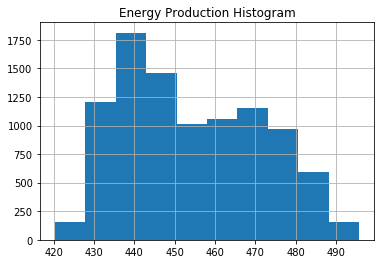

In [7]:
df.EP.hist()
plt.title("Energy Production Histogram")

We see that most energy production is around 440 - 450 watts and there is a longer tail. 

With this, we see that there is a certain baseline range that the plant tends to product, around 420 to 490, and within that range variables can have certain effects. Let's plot all the distributions to compare them.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000296ACA18128>,
      dtype=object)

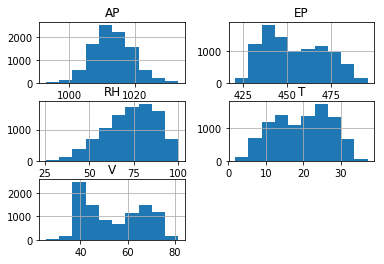

In [8]:
df.hist()

AP (pressure) seems to follow a normal distributions. RH (humidity) is left skewed. V (exahst vaccum) and T both seem to have 2 peeks.

Now let's see if there are any correlations. Here we use the Pearson R coeficent. This is important for us as correlations can tell us how variables relate linerarly and if it is appropriate to use a linear model.

In [9]:
corr_matrix = df.corr()

In [10]:
corr_matrix.EP

T    -0.948128
V    -0.869780
AP    0.518429
RH    0.389794
EP    1.000000
Name: EP, dtype: float64

We see a really strong negative relationship with T (Temperature) and V (Exauhst Vaccum) and weak positive relationships with AP (Pressure) and RH (Humidity). 

Let's visualize these with scatterplots.

Text(0.5, 1.0, 'Temperature vs Energy Production')

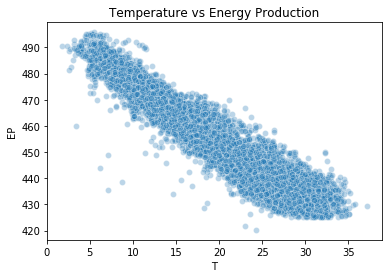

In [11]:
import seaborn as sns
sns.scatterplot(df["T"], df.EP, alpha = .3)
plt.title("Temperature vs Energy Production")

As we saw from the Pearson Correlation there is a clear negative correlation. There are a few outliers where T is low yet the EP is somewhat lower than normal. The opposite is not true though. We don't see values with High T and high EP. This makes it seem like there is another variable causing T to be lower during those days. We need to keep these points when we construct our model. 

Text(0.5, 1.0, 'Exhaust Vacuum vs Energy Production')

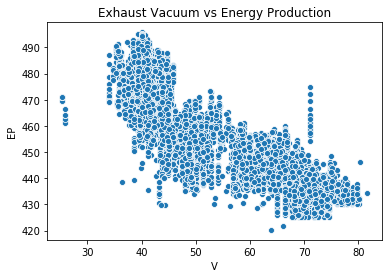

In [12]:
sns.scatterplot(df.V, df.EP)
plt.title('Exhaust Vacuum vs Energy Production')

This also is a negative relationship. Here though, it does not seem to be linear. Also we see a few points with high V and medium to low EP and vice verse. 

Based on these 2 things, we may be inclined to make a linear model based on V and EP. Let's see first though if V and EP are correlated

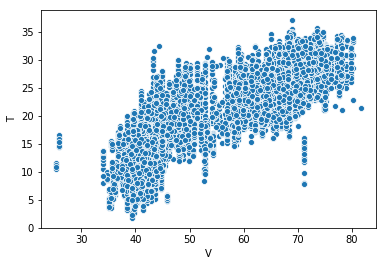

In [13]:
 sns.scatterplot(df.V, df["T"])

There does seem to a positive relationship with T and V where the higher T is the higher V is. When we construct our model we should see whether or not we actually need both variables since they may be contributing the same points.

Let's look at RH which had a .5 correlation value

Text(0.5, 1.0, 'Humidity vs Energy Production')

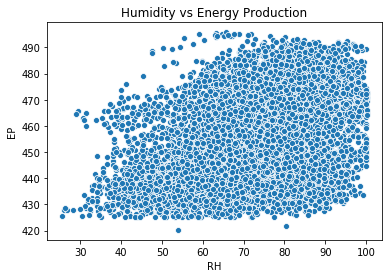

In [14]:
sns.scatterplot(df.RH, df.EP)
plt.title("Humidity vs Energy Production")

We see that although they are correlated, as the higher the humidity the higher the energy production, there is a high amount of variance. With a humidity of 70 for example, the actual value energy production ranged between 420 and 490. We would need to use this variable in the context of other features. 

Text(0.5, 1.0, 'Pressure vs Energy Production')

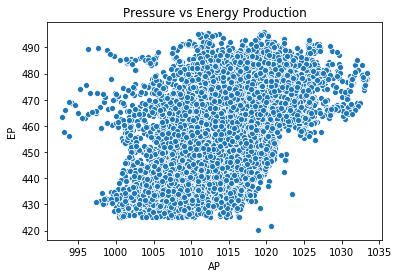

In [15]:
sns.scatterplot(df.AP, df.EP)
plt.title('Pressure vs Energy Production')

### Preparing the Data

All we really need to do for this step is split the into a training set and test set. Although we could standarize our variables, since we are doing a simple regression by not doing so we could more easily interpret our coeficents.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
y = df.EP
X = df.drop("EP", axis = 1, inplace = False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
len(X_train), len(X_test)

(7654, 1914)

Let's use mean squared error as our cost metric. It is a usefull meassurement to see how far away we are from the mean.

Let's establish a baseline model. There are a few ways we can do this but let's see what our mse would be if we just choose the mean every time

In [19]:
mean = df.EP.mean()
arr = np.arange((len(y_train)))
arr.fill(mean)

In [20]:
arr

array([454, 454, 454, ..., 454, 454, 454])

In [21]:
from sklearn.metrics import mean_squared_error
baseline = mean_squared_error(y_train,arr)
baseline

291.71442652208003

So we get an mse value of around 291. We will use this to compare our models.

### Creating our model

We have 2 choices. We can create a linear regression model with all possible combinations of our variables. This sounds reasonable as we only have 4 variables. The problem with this is that we already know if we do this that the model that incorporates all 4 of our variables will perform the best since you can't lose any info by incorporating another variable. Instead what we will do is make 1 model with Exahust Vacuum and the other variables and another model with Temperature and the other variables since we know from our EDA that T and V are very correlated.

In [22]:
m1Features = X_train.drop('V', axis = 1, inplace = False)
m2Features = X_train.drop('T', axis = 1, inplace = False)

In [23]:
from sklearn.model_selection import cross_val_score, cross_validate

In [24]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

There is no mean squared error but we could use neg_mean_squared_error and multiply by -1. We should use cross validation. We could train our model on k times, each time training on k-1 of the folds and leaving one out for the validation set. We choose 5 folds as 5 is a standard number and we don't want our folds to become to smalll as we don't have that many points.

In [25]:
from sklearn import linear_model
import numpy as np
model1 = linear_model.LinearRegression()
model2 = linear_model.LinearRegression()
m1scores = cross_val_score(model1, m1Features, y_train, cv=5, scoring = 'neg_mean_squared_error')
m2scores = cross_val_score(model2, m2Features, y_train, cv=5, scoring = 'neg_mean_squared_error')
m1scores = m1scores * -1
m2scores = m2scores * -1


In [26]:
print(m1scores.mean())
print(m2scores.mean())
m1scores > m2scores

23.122468254840552
57.504962081768795


array([False, False, False, False, False])

Our first model seems to be doing much better than the second model. Both overall are doing much better than the baseline. 

In [27]:
print(m1scores.std())
print(m2scores.std())

1.0551613980491574
0.8420349106798863


The standard deviations in cv scores are both low. 

Let's get the equations from these models. 

In [28]:
model1.fit(m1Features, y_train)
model1.intercept_

487.37896341377535

The intercept is very close to the max of the Energy Production...

In [29]:
print(model1.coef_)
print(m1Features.columns)

[-2.38325627  0.02839706 -0.20386697]
Index(['T', 'AP', 'RH'], dtype='object')


The coeficents match up to the order of the index in the botumn. We see that the temperature seems to be the most important factor with a coeficent of -2.38. This is consistant with how we saw that this feature has the highest correlation with energy production.

In [30]:
model2.fit(m2Features, y_train)
print(model2.coef_)
print(m2Features.columns)

[-1.00182943  0.55597419  0.16214458]
Index(['V', 'AP', 'RH'], dtype='object')


In our second model, we see that V is the most important factor. The other variables like AP and RH though have more weight. We see from this that T is the more important feature. 

### Evaluating our chosen model

Since model1 with temperature had the better cross val scores, let's select it and evaluate it on our test data.

In [31]:
preds = model1.predict(X_test.drop('V', axis = 1)) # recall that our model 1 does not include V

In [32]:
mean_squared_error(y_test,preds)

22.655320432415575

Our mean squared error is only slightly worse and we aren't heavily overfitting.

To evaluate if the linear model was the correct choice, we should plot the residuals.

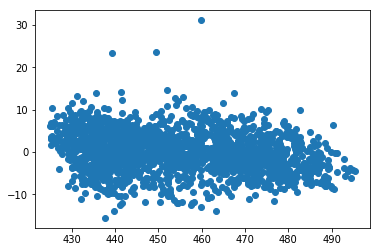

In [33]:
plt.scatter(y_test, preds - y_test)

Our points are scattered around 0 randomly. This tells us that our model does seem to be linear. There are a couple of outlier points where the actual value is over 20 from the true value. These points may be increasing our mse score significantly. Overall most points are within 10 of the true value.

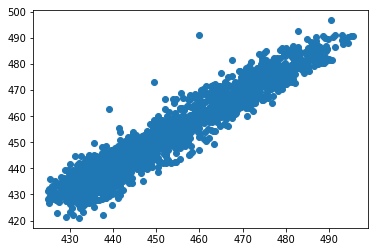

In [34]:
plt.scatter(y_test, preds)

We say that our points make a line with the actual values. 

### Conclusions

1. We were able to create a linear model that can create a good approximation of how much energy a power plant can produce using temperature, humidity, and pressure.
2. Temperature has the highest weight in the model with a coeficent of around -2. This seems to be the most significant impact of how much energy is being produced. Increasing the temperature would be a simple way to increase output. 
